In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from IPython.display import display

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# Load and pick Datas

In [2]:
# 读取训练集和测试集为 DataFrame
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

print train_data.shape
display(train_data.head(1))
# display(train_data.info())

print test_data.shape
display(test_data.head(1))
# display(test_data.info())
train_length = train_data.shape[0]

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500


(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal


# Filling up missing values

In [3]:
def conbine_train_test_data():
    train_data2 = train_data.drop('SalePrice', axis=1)
    return pd.concat([train_data2, test_data])

conbined_data = conbine_train_test_data()
conbined_data.shape

(2919, 80)

In [4]:
# 存在缺失数据的列名
has_null_columns = conbined_data.columns[conbined_data.isnull().any()].tolist()
# 每列包含多少缺失数据
conbined_data[has_null_columns].isnull().sum()

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

## Data Cleaning Plan
* `LotFrontage`: Linear feet of street connected to property. Impute mean, or maybe see if there's a correlation with `LotArea` (like square root?).

* `Alley`: Type of alley access to property -> Many missing values, I would presume that these properties just don't have an alley access.

* `MasVnrType/MasVnrArea` -> both have 8 values missing, I presume they are the same ones. Either set as "None"/0 or use most frequent value/median.

* `Bsmt... Variables`: A  number of variables in connection with the basement. About the same number of missing values. However, there are two basement-related variables without missing values "BsmtFinSF1" and "BsmtFinSF2" - look at those and then decide what to do with the missing values.

* `Electrical`: Just one missing value - here just impute most frequent one.

* `FireplaceQu`: I assume the properties with missing values just don't have a fireplace. There's also the variable Fireplaces (without missing values) - check this and then decide.

* `Garage ... Variables`: 81 missing in these columns. However, there are some Garage-related variables without missing values: GarageCars, GarageArea - check these and then decide.

* `PoolQC` - probably no pool - but check against PoolArea (which has no missing values).

* `Fence`: Many missing values - probably no fence, just impute 'None'

* `MiscFeature`: Assuming none - probably no special features, just impute 'None'

In [5]:
def fill_missing_conbined_data(column, value):
    conbined_data.loc[conbined_data[column].isnull(),column] = value

** LotFrontage/LotArea **

对于缺失的 LotFrontage，一般采用平均值进行填充，但考虑到可能与 LotArea 存在关系。

In [6]:
# Compute pairwise correlation of columns, excluding NA/null values
conbined_data['LotFrontage'].corr(conbined_data['LotArea'])

0.48989557038716691

LotArea: Lot size in square feet。LotArea 平方英尺为单位。考虑单位同一将 LotArea 进行 `sqrt()`

In [7]:
conbined_data['SqrtLotArea'] = np.sqrt(conbined_data['LotArea'])
conbined_data['LotFrontage'].corr(conbined_data['SqrtLotArea'])

0.64765803986178294

相关系数为 0.64765803986178294，说明 LotFrontage 与 LotArea 之间存在一定的正相关。下面对LotFrontage 与 LotArea 进行拟合。 

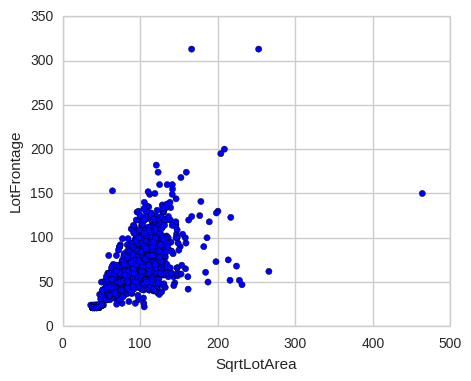

In [8]:
# 绘制 LotFrontage 与 LotArea 原始数据
lot_datas = conbined_data[['LotFrontage','SqrtLotArea']].dropna()
plt.figure(figsize=(5,4))
plt.scatter(lot_datas['SqrtLotArea'], lot_datas['LotFrontage'])
plt.xlabel("SqrtLotArea") 
plt.ylabel("LotFrontage") 

In [9]:
from sklearn.linear_model import LinearRegression

# Create linear regression object
regr = LinearRegression()

In [10]:
lotFrontage = lot_datas.iloc[:,0].values
sqrtLotArea = lot_datas.iloc[:,1].values

length = lotFrontage.shape[0]
lotFrontage = lotFrontage.reshape(length, 1)
sqrtLotArea = sqrtLotArea.reshape(length, 1)

# Train the model using the training sets
regr.fit(sqrtLotArea, lotFrontage)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
# The coefficients
print('Coefficients: \n', regr.coef_)

('Coefficients: \n', array([[ 0.6430147]]))


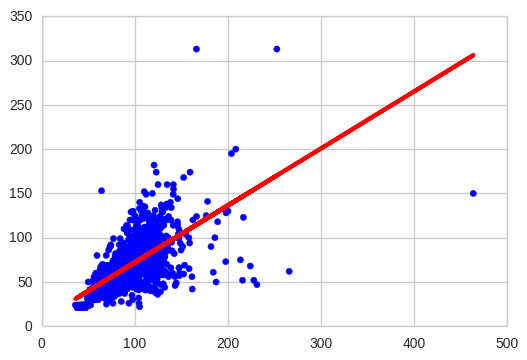

In [12]:
plt.scatter(sqrtLotArea, lotFrontage,  color='blue')
plt.plot(sqrtLotArea, regr.predict(sqrtLotArea), color='red',
         linewidth=3)

In [13]:
def fill_missing_lotfrontage(sqrt_lotarea):
    """
    填充缺失的 LotFrontage 数据
    """
    return 0.6430147 * sqrt_lotarea

column = conbined_data['LotFrontage'].isnull()
conbined_data['LotFrontage'][column] = conbined_data['SqrtLotArea'][column].map(fill_missing_lotfrontage)

In [14]:
conbined_data[conbined_data['LotFrontage'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SqrtLotArea


In [15]:
conbined_data.drop('SqrtLotArea', axis=1, inplace=True)
conbined_data.shape

(2919, 80)

** Alley **

In [16]:
conbined_data.shape, conbined_data[conbined_data['Alley'].isnull()].shape

((2919, 80), (2721, 80))

2919 条数据缺失 2721 条，缺失数据过多(93.2%),将缺失数据填充为 NA（NA->No alley access）。

In [17]:
fill_missing_conbined_data('Alley', 'NA')
conbined_data[conbined_data['Alley'].isnull()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition


** MasVnrType / MasVnrArea **

方形单板砌体类型/面积，将缺失数据填充为出现次数最多的类型

In [18]:
conbined_data['MasVnrType'].fillna('None', inplace=True)
conbined_data['MasVnrArea'].fillna(0, inplace=True)

In [19]:
conbined_data['MasVnrType'].isnull().sum(), conbined_data['MasVnrArea'].isnull().sum()

(0, 0)

** BsmtQual / BsmtCond / BsmtExposure / BsmtFinType1 / BsmtFinType2 **

缺失 37 / 38 条数据。

In [20]:
basement_cols=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','BsmtFinSF1','BsmtFinSF2']

In [21]:
# 对于缺失的字符串类型的数据填充为 NA，表示 No Basement
for column in basement_cols:
    if 'FinSF'not in column:
        # NA	No Basement
        fill_missing_conbined_data(column, 'NA')

In [22]:
# 对于数值型的 BsmtFinSF1 和 BsmtFinSF2
fill_missing_conbined_data('BsmtFinSF1', 0)
fill_missing_conbined_data('BsmtFinSF2', 0)

In [23]:
conbined_data[basement_cols].isnull().sum()

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
BsmtFinSF1      0
BsmtFinSF2      0
dtype: int64

** Electrical **

缺失一条数据,填充为出现次数最多的。

In [24]:
fill_missing_conbined_data('Electrical', conbined_data['Electrical'].max())

** FireplaceQu **

缺失 1420 条数据
* Fireplaces: Number of fireplaces
* FireplaceQu: Fireplace quality

所以 FireplaceQu 与 Fireplaces 有关系

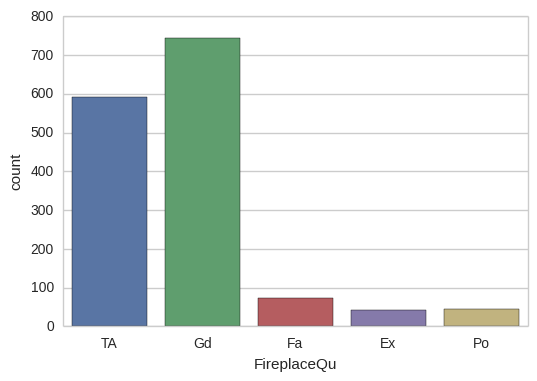

In [25]:
conbined_data['FireplaceQu'].value_counts()
conbined_data[['FireplaceQu', 'Fireplaces']].groupby(['FireplaceQu']).median()
sns.countplot(conbined_data['FireplaceQu'])

In [26]:
# 对于 Fireplaces 为 0 的，FireplaceQu 设置为 NA，表示 No Fireplace，此即缺失的 1420 条数据的情况
fill_missing_conbined_data('FireplaceQu', 'NA')

** PoolQC **

PoolQC 缺失 2909 条数据，是否与 PoolArea 有关。

In [27]:
fill_missing_conbined_data('PoolQC', 'NA')

** MiscFeature **

In [28]:
fill_missing_conbined_data('MiscFeature', 'NA')

** Fence **

In [29]:
fill_missing_conbined_data('Fence', 'NA')

** Garages **

In [30]:
garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']
conbined_data[garage_cols][conbined_data['GarageType'].isnull()==True].head(1)

,GarageType,GarageQual,GarageCond,GarageYrBlt,GarageFinish,GarageCars,GarageArea
39,NaN,NaN,NaN,NaN,NaN,0.0,0.0


In [31]:
# 对于缺失的字符串类型的数据填充为 NA，表示 No Garage
for column in garage_cols:
    if column != 'GarageCars' and column != 'GarageArea':
        # NA	No Basement
        fill_missing_conbined_data(column, 'NA')
    else:
        fill_missing_conbined_data(column, 0)

** MSZoning **

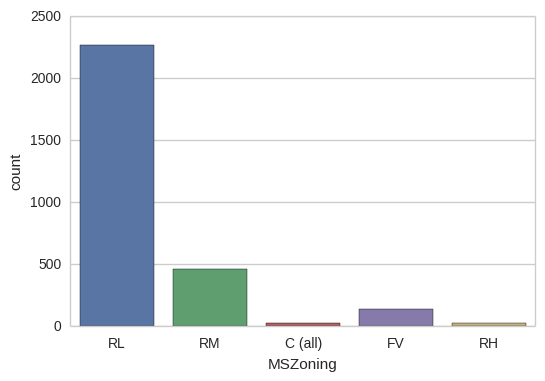

In [32]:
sns.countplot(conbined_data['MSZoning'])

In [33]:
conbined_data['MSZoning'].max()

'RM'

In [34]:
fill_missing_conbined_data('MSZoning', conbined_data['MSZoning'].max())

** Utilities **

In [35]:
fill_missing_conbined_data('Utilities', conbined_data['Utilities'].max())

** Exterior1st / Exterior2nd**

In [36]:
fill_missing_conbined_data('Exterior1st', conbined_data['Exterior1st'].max())

In [37]:
fill_missing_conbined_data('Exterior2nd', conbined_data['Exterior2nd'].max())

** BsmtUnfSF / TotalBsmtSF **

BsmtUnfSF: Unfinished square feet of basement area<br/>
BsmtFinSF2: Type 2 finished square feet<br/>
BsmtFinSF1: Type 1 finished square feet<br/>
TotalBsmtSF: Total square feet of basement area

测试发现：`TotalBsmtSF = BsmtFinSF1 + BsmtFinSF2 + BsmtUnfSF`

In [38]:
regr = LinearRegression()
bsmt_data = conbined_data[['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF']].dropna()

In [39]:
bsmt_x = bsmt_data.iloc[:,0:-1].values
bsmt_y = bsmt_data.iloc[:,-1].values

length = bsmt_x.shape[0]
bsmt_y = bsmt_y.reshape(length, 1)

# Train the model using the training sets
regr.fit(bsmt_x, bsmt_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [40]:
# The coefficients
print('Coefficients: \n', regr.coef_)

('Coefficients: \n', array([[ 1.,  1.,  1.]]))


In [41]:
conbined_data[['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF']][conbined_data['BsmtUnfSF'].isnull()]

,BsmtUnfSF,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF
660,NaN,0.0,0.0,NaN


In [42]:
# 可以发现，对于缺失的 TotalBsmtSF 和 BsmtUnfSF 填充为0
fill_missing_conbined_data('BsmtUnfSF', 0)
fill_missing_conbined_data('TotalBsmtSF', 0)

** BsmtFullBath / BsmtHalfBath **

BsmtFullBath: Basement full bathrooms<br/>
BsmtHalfBath: Basement half bathrooms<br/>
FullBath: Full bathrooms above grade<br/>
HalfBath: Half baths above grade

In [43]:
conbined_data['FullBath'].corr(conbined_data['BsmtFullBath'])

-0.018815125742370497

In [44]:
fill_missing_conbined_data('BsmtFullBath', 0)
fill_missing_conbined_data('BsmtHalfBath', 0)

** KitchenQual **

KitchenAbvGr: Kitchens above grade<br/>
KitchenQual: Kitchen quality

In [45]:
print conbined_data['KitchenQual'].max()
conbined_data[['KitchenAbvGr', 'KitchenQual']].groupby('KitchenQual').mean()

TA


,KitchenAbvGr
KitchenQual,
Ex,1.000000
Fa,1.128571
Gd,1.004344
TA,1.077748


In [46]:
# 差别并不大，填充为1
fill_missing_conbined_data('KitchenQual', conbined_data['KitchenQual'].max())

** SaleType / Functional **

In [47]:
fill_missing_conbined_data('SaleType', conbined_data['SaleType'].max())
fill_missing_conbined_data('Functional', conbined_data['Functional'].max())

完成了缺失数据的填充。

In [48]:
# 存在缺失数据的列名
has_null_columns = conbined_data.columns[conbined_data.isnull().any()].tolist()
# 每列包含多少缺失数据
conbined_data[has_null_columns].isnull().sum()

Series([], dtype: float64)

# Feature Engineering

** 时间属性（YearBuilt、GarageYrBlt）**

In [49]:
built_year_data = conbined_data[['YearBuilt', 'GarageYrBlt']][conbined_data['GarageYrBlt'] != 'NA']

In [50]:
built_year_data['GarageYrBlt'] = built_year_data['GarageYrBlt'].map(lambda g : int(g))
built_year_data['GarageYrBlt'].corr(built_year_data['YearBuilt'])

0.83481237316310175

可以发现 YearBuilt、GarageYrBlt 之间存在很高的相关性。

In [51]:
built_year_data.head(1)

,YearBuilt,GarageYrBlt
0,2003,2003


('Coefficients: \n', array([[ 0.72418557]]))


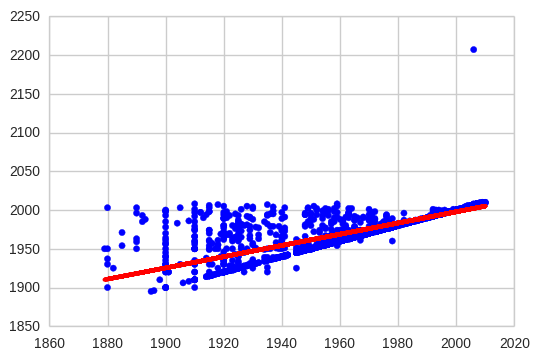

In [52]:
regr = LinearRegression()
garage_year = built_year_data.loc[:,'GarageYrBlt'].values
built_year = built_year_data.loc[:,'YearBuilt'].values

length = garage_year.shape[0]
garage_year = garage_year.reshape(length, 1)
built_year = built_year.reshape(length, 1)

# Train the model using the training sets
regr.fit(built_year, garage_year)
plt.scatter(built_year, garage_year,  color='blue')
plt.plot(built_year, regr.predict(built_year), color='red',
         linewidth=3)

# The coefficients
print('Coefficients: \n', regr.coef_)

In [53]:
# 对于 NA 的 GarageYrBlt，进行填充
conbined_data['GarageYrBlt'] = conbined_data.apply(lambda row : regr.predict(row['YearBuilt'])
                                                      if row['GarageYrBlt'] == 'NA' else row['GarageYrBlt'],
                                                       axis=1)

conbined_data['GarageYrBlt'] = conbined_data['GarageYrBlt'].map(lambda g : float(g))

In [54]:
conbined_data['GarageYrBlt'].head()

0    2003.0
1    1976.0
2    2001.0
3    1998.0
4    2000.0
Name: GarageYrBlt, dtype: float64

对于 MSSubClass 的数值仅仅代表 the type of dwelling，所以将其编码。

In [55]:
np.array(set(conbined_data['MSSubClass']))

array(set([160, 70, 40, 75, 45, 80, 50, 20, 30, 150, 120, 180, 90, 60, 190, 85]), dtype=object)

In [56]:
mssubclass_dict = {
    20: 'SC20',
    30: 'SC30',
    40: 'SC40',
    45: 'SC45',
    50: 'SC50',
    60: 'SC60',
    70: 'SC70',
    75: 'SC75',
    80: 'SC80',
    85: 'SC85',
    90: 'SC90',
    120: 'SC120',
    150: 'SC150',
    160: 'SC160',
    180: 'SC180',
    190: 'SC190',
}
conbined_data['MSSubClass'] = conbined_data['MSSubClass'].replace(mssubclass_dict)

In [57]:
np.array(set(conbined_data['MSSubClass']))

array(set(['SC20', 'SC30', 'SC50', 'SC40', 'SC150', 'SC90', 'SC85', 'SC160', 'SC80', 'SC120', 'SC190', 'SC75', 'SC70', 'SC60', 'SC180', 'SC45']), dtype=object)

对于那些存在大小特质的属性进行编码。

In [58]:
conbined_data = conbined_data.replace(
    {'Street': {'Grvl': 0, 'Pave': 1},
     'Alley': {'NA':0, 'Grvl': 1, 'Pave': 2},
     'LotShape': {'IR1':2, 'IR2':1, 'IR3':0, 'Reg':3},
     'LandContour': {'Low':0, 'HLS':1, 'Bnk':2, 'Lvl':3},
     'Utilities': {'AllPub':3, 'NoSeWa': 1, 'NoSewr': 2, 'ELO': 0},
     'LandSlope': {'Sev':0, 'Gtl':2, 'Mod':1},
     'ExterQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
     'ExterCond': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
     'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1,'NA': 0},
     'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2,'Po': 1,'NA': 0},
     'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2,'Po': 1,'NA': 0},
     'BsmtFinType1': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
     'BsmtFinType2': {'NA':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6},
     'HeatingQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1,'Po': 0},
     'CentralAir': {'N':0, 'Y':1},
     'Electrical': {'Mix':0, 'FuseP':1, 'FuseF':2, 'FuseA':3, 'SBrkr':5},
     'KitchenQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Po': 0},
     'Functional': {'Typ':7,'Min1':6,'Min2':5,'Mod':4,'Maj1':3,'Maj2':2,'Sev':1,'Sal': 0},
     'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
     'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
     'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
     'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'NA': 0},
     'Fence': {'GdPrv': 4, 'GdWo': 3, 'MnPrv': 2, 'MnWw': 1, 'NA': 0},
    })

Neighborhood 属性表示的是附近的地名，可将其转为经纬度。

In [59]:
# 纬度
conbined_data["latitude"] = conbined_data.Neighborhood.replace(
                                               {'Blmngtn' : 42.062806,
                                                'Blueste' : 42.009408,
                                                'BrDale' : 42.052500,
                                                'BrkSide': 42.033590,
                                                'ClearCr': 42.025425,
                                                'CollgCr': 42.021051,
                                                'Crawfor': 42.025949,
                                                'Edwards': 42.022800,
                                                'Gilbert': 42.027885,
                                                'GrnHill': 42.000854,
                                                'IDOTRR' : 42.019208,
                                                'Landmrk': 42.044777,
                                                'MeadowV': 41.991866,
                                                'Mitchel': 42.031307,
                                                'NAmes'  : 42.042966,
                                                'NoRidge': 42.050307,
                                                'NPkVill': 42.050207,
                                                'NridgHt': 42.060356,
                                                'NWAmes' : 42.051321,
                                                'OldTown': 42.028863,
                                                'SWISU'  : 42.017578,
                                                'Sawyer' : 42.033611,
                                                'SawyerW': 42.035540,
                                                'Somerst': 42.052191,
                                                'StoneBr': 42.060752,
                                                'Timber' : 41.998132,
                                                'Veenker': 42.040106})
# 经度
conbined_data["longitude"] = conbined_data.Neighborhood.replace(
                                               {'Blmngtn' : -93.639963,
                                                'Blueste' : -93.645543,
                                                'BrDale' : -93.628821,
                                                'BrkSide': -93.627552,
                                                'ClearCr': -93.675741,
                                                'CollgCr': -93.685643,
                                                'Crawfor': -93.620215,
                                                'Edwards': -93.663040,
                                                'Gilbert': -93.615692,
                                                'GrnHill': -93.643377,
                                                'IDOTRR' : -93.623401,
                                                'Landmrk': -93.646239,
                                                'MeadowV': -93.602441,
                                                'Mitchel': -93.626967,
                                                'NAmes'  : -93.613556,
                                                'NoRidge': -93.656045,
                                                'NPkVill': -93.625827,
                                                'NridgHt': -93.657107,
                                                'NWAmes' : -93.633798,
                                                'OldTown': -93.615497,
                                                'SWISU'  : -93.651283,
                                                'Sawyer' : -93.669348,
                                                'SawyerW': -93.685131,
                                                'Somerst': -93.643479,
                                                'StoneBr': -93.628955,
                                                'Timber' : -93.648335,
                                                'Veenker': -93.657032})

# Ames city 的经纬度：经度-93.63191310000002，纬度42.0307812，计算距离
conbined_data["NeighborDistance"] = np.sqrt(np.power((conbined_data["longitude"] - (-93.63191310000002)),2) + \
                                    np.power((conbined_data["latitude"] - 42.0307812),2))

display(conbined_data["NeighborDistance"].head())

# Bin by neighborhood (a little arbitrarily). Values were computed by: 
# train_df["SalePrice"].groupby(train_df["Neighborhood"]).median().sort_values()
neighborhood_map = {
    "MeadowV" : 0,  #  88000
    "IDOTRR" : 1,   # 103000
    "BrDale" : 1,   # 106000
    "OldTown" : 1,  # 119000
    "Edwards" : 1,  # 119500
    "BrkSide" : 1,  # 124300
    "Sawyer" : 1,   # 135000
    "Blueste" : 1,  # 137500
    "SWISU" : 2,    # 139500
    "NAmes" : 2,    # 140000
    "NPkVill" : 2,  # 146000
    "Mitchel" : 2,  # 153500
    "SawyerW" : 2,  # 179900
    "Gilbert" : 2,  # 181000
    "NWAmes" : 2,   # 182900
    "Blmngtn" : 2,  # 191000
    "CollgCr" : 2,  # 197200
    "ClearCr" : 3,  # 200250
    "Crawfor" : 3,  # 200624
    "Veenker" : 3,  # 218000
    "Somerst" : 3,  # 225500
    "Timber" : 3,   # 228475
    "StoneBr" : 4,  # 278000
    "NoRidge" : 4,  # 290000
    "NridgHt" : 4,  # 315000
}

conbined_data["NeighborhoodLevelBin"] = conbined_data["Neighborhood"].map(neighborhood_map)

# 去掉字符串类型的 Neighborhood
conbined_data.drop('Neighborhood', axis=1, inplace=True)
conbined_data.drop('latitude', axis=1, inplace=True)
conbined_data.drop('longitude', axis=1, inplace=True)

0    0.054604
1    0.026794
2    0.054604
3    0.012657
4    0.031042
Name: NeighborDistance, dtype: float64

YearBuilt建造时间，YearRemodAdd修建时间，确定是否翻新改造过

In [60]:
conbined_data['RemodYears'] = conbined_data['YearRemodAdd'] - conbined_data['YearBuilt']

In [61]:
conbined_data['GarageBltYears'] = conbined_data['GarageYrBlt'] - conbined_data['YearBuilt']

In [62]:
conbined_data['GarageBltYears'].head()

0     0.0
1     0.0
2     0.0
3    83.0
4     0.0
Name: GarageBltYears, dtype: float64

In [63]:
# 距离现在建造的时间间隔
conbined_data['Now_YearBuilt'] = 2017 - conbined_data['YearBuilt']
conbined_data['Now_YearRemodAdd'] = 2017 - conbined_data['YearRemodAdd']
conbined_data['Now_GarageYrBlt'] = 2017 - conbined_data['GarageYrBlt']

conbined_data.drop('YearBuilt', axis=1, inplace=True)
conbined_data.drop('YearRemodAdd', axis=1, inplace=True)
conbined_data.drop('GarageYrBlt', axis=1, inplace=True)

In [64]:
conbined_data[['Now_YearBuilt','Now_YearRemodAdd','Now_GarageYrBlt']].head()

,Now_YearBuilt,Now_YearRemodAdd,Now_GarageYrBlt
0,14,14,14.0
1,41,41,41.0
2,16,15,16.0
3,102,47,19.0
4,17,17,17.0


房子卖的月份为数值类型，将其转为字符串类型

In [65]:
conbined_data['MoSold'] = conbined_data['MoSold'].map(lambda m : str(m))

In [66]:
conbined_data['MoSold'].head()

0     2
1     5
2     9
3     2
4    12
Name: MoSold, dtype: object

# Create new features

Ref: [juliencs : A study on Regression applied to the Ames dataset
](https://www.kaggle.com/juliencs/house-prices-advanced-regression-techniques/a-study-on-regression-applied-to-the-ames-dataset)
- Simplifications of existing features
- Combinations of existing features
- Polynomials on the top 10 existing features

In [67]:
# 1.Simplifications of existing features
conbined_data["SimplOverallQual"] = conbined_data.OverallQual.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, # bad
                                                             4 : 2, 5 : 2, 6 : 2, # average
                                                             7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                            })
conbined_data["SimplOverallCond"] = conbined_data.OverallCond.replace(
                                                            {1 : 1, 2 : 1, 3 : 1, # bad
                                                             4 : 2, 5 : 2, 6 : 2, # average
                                                             7 : 3, 8 : 3, 9 : 3, 10 : 3 # good
                                                             })

In [68]:
# 2.Combinations of existing features

# Overall quality of the house
conbined_data["OverallGrade"] = conbined_data["OverallQual"] * conbined_data["OverallCond"]
# Overall quality of the garage
conbined_data["GarageGrade"] = conbined_data["GarageQual"] * conbined_data["GarageCond"]
# Overall quality of the exterior
conbined_data["ExterGrade"] = conbined_data["ExterQual"] * conbined_data["ExterCond"]
# Overall kitchen score
conbined_data["KitchenScore"] = conbined_data["KitchenAbvGr"] * conbined_data["KitchenQual"]
# Overall fireplace score
conbined_data["FireplaceScore"] = conbined_data["Fireplaces"] * conbined_data["FireplaceQu"]
# Overall garage score
conbined_data["GarageScore"] = conbined_data["GarageArea"] * conbined_data["GarageQual"]
# Overall pool score
conbined_data["PoolScore"] = conbined_data["PoolArea"] * conbined_data["PoolQC"]

# Total number of bathrooms
conbined_data["TotalBath"] = conbined_data["BsmtFullBath"] + (0.5 * conbined_data["BsmtHalfBath"]) + \
conbined_data["FullBath"] + (0.5 * conbined_data["HalfBath"])

# Total yard area in square feet
conbined_data["TotalPorchSF"] = conbined_data["OpenPorchSF"] + conbined_data["EnclosedPorch"] +\
                                conbined_data["3SsnPorch"] + conbined_data["ScreenPorch"]
# Total SF for house (living, basement, porch, pool)
conbined_data["AllSF"] = conbined_data["GrLivArea"] + conbined_data["TotalBsmtSF"] + \
                         conbined_data["TotalPorchSF"] + conbined_data["WoodDeckSF"] + \
                         conbined_data["PoolArea"]

# Has masonry veneer or not
conbined_data["HasMasVnr"] = conbined_data.MasVnrType.replace(
    {"BrkCmn" : 1, "BrkFace" : 1, "CBlock" : 1, "Stone" : 1, "None" : 0})
# House completed before sale or not
conbined_data["BoughtOffPlan"] = conbined_data.SaleCondition.replace(
    {"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})

In [69]:
# 3.Polynomials on the top 10 existing features
train_data_new = conbined_data.iloc[:train_length,:]
# 添加价格
train_data_new['SalePrice'] = train_data['SalePrice']
train_data_new.shape

(1460, 98)

In [70]:
print("Find most important features relative to target")
corr = train_data_new.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
corr_saleprice = corr.SalePrice
corr_saleprice.head(11)

del train_data_new

Find most important features relative to target


In [71]:
# 3.Polynomials on the top 10 existing features
top_n = 10
poly_columns = corr_saleprice.index.values[1:top_n+1]
for column in poly_columns:
    conbined_data[column+'-s2'] = conbined_data[column] ** 2
    conbined_data[column+'-s3'] = conbined_data[column] ** 2
    conbined_data[column+'-sq'] = np.sqrt(conbined_data[column])

** Feature Scale / Skew **

In [72]:
from sklearn.preprocessing import MinMaxScaler
# remove warnings
import warnings
warnings.filterwarnings('ignore')

num_column_names = conbined_data.select_dtypes(exclude=['object']).columns.values
num_column_names = num_column_names[1:]
display(num_column_names)

display(conbined_data[num_column_names].head())
conbined_data[num_column_names] = conbined_data[num_column_names].apply(
                           lambda x: MinMaxScaler().fit_transform(x))

display(conbined_data[num_column_names].head())

array(['LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LandSlope', 'OverallQual',
       'OverallCond', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence',
       'MiscVal', 'YrSold', 'NeighborDistance', 'NeighborhoodLevelBin',
       'RemodYears', 'GarageBltYears', 'Now_YearBuilt', 'Now_YearRemodAdd',
       'Now_GarageYrBlt', 'SimplOverallQual', 'SimplOve

,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,...,KitchenQual-sq,GarageCars-s2,GarageCars-s3,GarageCars-sq,TotalBath-s2,TotalBath-s3,TotalBath-sq,GarageScore-s2,GarageScore-s3,GarageScore-sq
0,65.0,8450,1,0,3,3,3,2,7,5,...,1.732051,4.0,4.0,1.414214,12.25,12.25,1.870829,2702736.0,2702736.0,40.546270
1,80.0,9600,1,0,3,3,3,2,6,8,...,1.414214,4.0,4.0,1.414214,6.25,6.25,1.581139,1904400.0,1904400.0,37.148351
2,68.0,11250,1,0,2,3,3,2,7,5,...,1.732051,4.0,4.0,1.414214,12.25,12.25,1.870829,3326976.0,3326976.0,42.708313
3,60.0,9550,1,0,2,3,3,2,7,5,...,1.732051,9.0,9.0,1.732051,4.00,4.00,1.414214,3709476.0,3709476.0,43.886217
4,84.0,14260,1,0,2,3,3,2,8,5,...,1.732051,9.0,9.0,1.732051,12.25,12.25,1.870829,6290064.0,6290064.0,50.079936


,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,...,KitchenQual-sq,GarageCars-s2,GarageCars-s3,GarageCars-sq,TotalBath-s2,TotalBath-s3,TotalBath-sq,GarageScore-s2,GarageScore-s3,GarageScore-sq
0,0.150685,0.033420,1.0,0.0,1.000000,1.0,1.0,1.0,0.666667,0.500,...,0.732051,0.16,0.16,0.632456,0.234375,0.234375,0.529137,0.092962,0.092962,0.552174
1,0.202055,0.038795,1.0,0.0,1.000000,1.0,1.0,1.0,0.555556,0.875,...,0.414214,0.16,0.16,0.632456,0.109375,0.109375,0.353115,0.065503,0.065503,0.505900
2,0.160959,0.046507,1.0,0.0,0.666667,1.0,1.0,1.0,0.666667,0.500,...,0.732051,0.16,0.16,0.632456,0.234375,0.234375,0.529137,0.114433,0.114433,0.581618
3,0.133562,0.038561,1.0,0.0,0.666667,1.0,1.0,1.0,0.666667,0.500,...,0.732051,0.36,0.36,0.774597,0.062500,0.062500,0.251687,0.127589,0.127589,0.597659
4,0.215753,0.060576,1.0,0.0,0.666667,1.0,1.0,1.0,0.777778,0.500,...,0.732051,0.36,0.36,0.774597,0.234375,0.234375,0.529137,0.216349,0.216349,0.682007


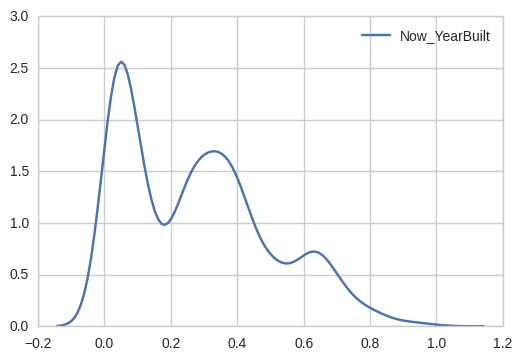

In [73]:
sns.kdeplot(conbined_data['Now_YearBuilt'])

![](http://itknowledgeexchange.techtarget.com/writing-for-business/files/2012/12/skewness-300x247.png)

In [74]:
# skewness 转换
conbined_data[num_column_names] = np.log1p(conbined_data[num_column_names])

** Dummy Encoding **

In [75]:
conbined_data = pd.get_dummies(conbined_data)

In [76]:
conbined_data.head(2)

,Id,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LandSlope,OverallQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,0.140357,0.032874,0.693147,0.0,0.693147,0.693147,0.693147,0.693147,0.510826,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0.184032,0.038061,0.693147,0.0,0.693147,0.693147,0.693147,0.693147,0.441833,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [77]:
print("New number of features : " + str(conbined_data.shape[1] - 1))

New number of features : 268


In [78]:
train_X = conbined_data.iloc[:train_length, 1:]
train_Y = train_data['SalePrice']
train_Id = conbined_data.iloc[:train_length, 0]

test_X = conbined_data.iloc[train_length:, 1:]
test_Id = conbined_data.iloc[train_length:, 0]

print("train_X : " + str(train_X.shape))
print("test_X : " + str(test_X.shape))
print("train_Y : " + str(train_Y.shape))

train_X : (1460, 268)
test_X : (1459, 268)
train_Y : (1460,)


(array([   5.,   12.,   54.,  184.,  470.,  400.,  220.,   90.,   19.,    6.]),
 array([ 10.46027076,  10.76769112,  11.07511148,  11.38253184,
         11.6899522 ,  11.99737256,  12.30479292,  12.61221328,
         12.91963363,  13.22705399,  13.53447435]),
 <a list of 10 Patch objects>)

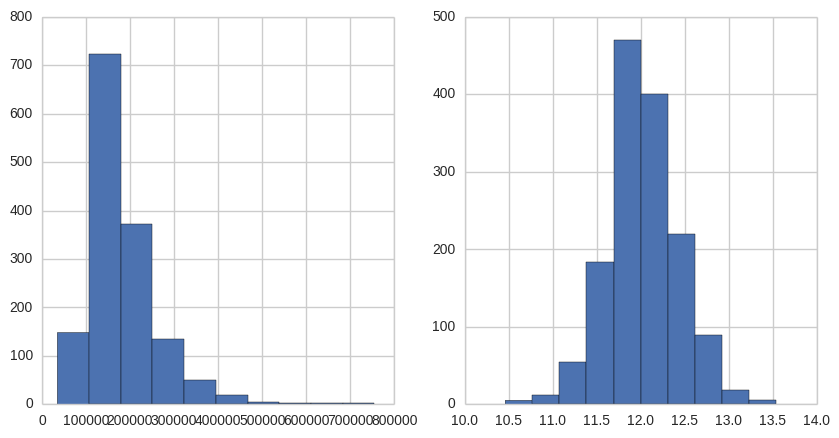

In [79]:
# 价格分布
fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))
axis1.hist(train_Y)
# Transform skewed numeric features using log(p+1) transformation making them more normal
train_Y = np.log1p(train_Y)
axis2.hist(train_Y)

# Save New Data

In [80]:
save_train = train_X.copy()
save_test = test_X.copy()
save_train['Id'] = train_Id
save_train['SalePrice'] = train_Y
save_test['Id'] = test_Id
save_train.head()

save_train.to_csv("data/new_train.csv")
save_test.to_csv("data/new_test.csv")

# Modeling

** 训练集上交叉验证获取最佳模型参数 **

In [ ]:
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer

# Partition the dataset in train + validation sets
cross_train_X, cross_validate_X, cross_train_Y, cross_validate_Y = \
                train_test_split(train_X, train_Y, test_size = 0.3, random_state = 0)

print("cross_train_X : " + str(cross_train_X.shape))
print("cross_train_Y : " + str(cross_train_Y.shape))
print("cross_validate_X : " + str(cross_validate_X.shape))
print("cross_validate_Y : " + str(cross_validate_Y.shape))

In [ ]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, cross_train_X, cross_train_Y, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_validate(model):
    rmse= np.sqrt(-cross_val_score(model, cross_validate_X, cross_validate_Y, scoring = scorer, cv = 10))
    return(rmse)

def predict_mean_squared_error(model, X, Y):
    predict_y = model.predict(X)
    return np.sqrt(np.power((predict_y - Y), 2))

Lasso Regression Model

In [ ]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(
            alphas = [0.0001, 0.0003, 0.001, 0.003, 0.009, 0.01, 0.03, 0.09, 0.1, 0.3, 1]
        ).fit(train_X, train_Y)

In [ ]:
lasso_error = predict_mean_squared_error(lasso, cross_train_X, cross_train_Y).mean()
lasso_error

In [ ]:
# coef = pd.Series(lasso.coef_, index = train_X.columns)

# # plotting feature importances!
# imp_coef = pd.concat([coef.sort_values().head(15),
#                      coef.sort_values().tail(15)])
# imp_coef.plot(kind = "barh")
# plt.title("Coefficients in the Lasso Model")

XGBRegressor Model

In [ ]:
import xgboost as xgb
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV

xgb_regr = xgb.XGBRegressor()

xgb_parameter_grid = {
                 'learning_rate' : [0.001, 0.025, 0.075, 0.1, 0.3, 0.6, 0.8, 1],
                 'n_estimators': [80,100,200,400,600,800,1000,1200,1400,1600,1800]
                 }
cross_validation = StratifiedKFold(train_Y, n_folds=5)
xgb_grid_search = GridSearchCV(xgb_regr,
                           param_grid=xgb_parameter_grid,
                           cv=cross_validation)

xgb_grid_search.fit(train_X, train_Y)

print('xgb Best score: {}'.format(xgb_grid_search.best_score_))
print('xgb Best parameters: {}'.format(xgb_grid_search.best_params_))

In [ ]:
xgb_error = predict_mean_squared_error(xgb_grid_search, cross_train_X, cross_train_Y).mean()
xgb_error

** 计算残差 residuals 验证模型的效果 **

In [ ]:
lasso_train_predict = lasso.predict(train_X)
xgb_train_predict = xgb_grid_search.predict(train_X)

residuals_lasso = lasso_train_predict - train_Y
residuals_xgb = xgb_train_predict - train_Y

In [ ]:
# 依据预测的 mean_squared_error 确定 voting 的权重
# xgb：0.02918017553888173，lasso：0.078234324232550001
weight_xgb = lasso_error / (xgb_error + lasso_error)
weight_lasso = xgb_error / (xgb_error + lasso_error)

voting_train_predict = weight_xgb * xgb_train_predict + weight_lasso * lasso_train_predict
residuals_voting = voting_train_predict - train_Y

In [ ]:
plt.plot(train_Id, residuals_lasso, c='blue')
plt.plot(train_Id, residuals_voting, c='yellow')
plt.plot(train_Id, residuals_xgb, c='red')

In [ ]:
print 'residuals_lasso = ', np.abs(residuals_lasso).mean()
print 'residuals_xgb = ', np.abs(residuals_xgb).mean()
print 'residuals_voting = ', np.abs(residuals_voting).mean()

可以看出，依据预测的平方误差设定的权重得到的加权结果的残差（黄色）要比单独的 lasso（蓝色）模型的残差要小很多，XGBRegressor 模型最好。

# Predict

In [ ]:
lasso_predictions = lasso.predict(test_X).astype(float)
lasso_predictions = np.power(np.e, lasso_predictions) - 1

print 'lasso predicts done.'

In [ ]:
xgb_predictions = xgb_grid_search.predict(test_X)
xgb_predictions = np.power(np.e, xgb_predictions) - 1

print 'xgb predicts done.'

In [ ]:
plt.plot(test_Id, lasso_predictions, c='red')
plt.plot(test_Id, xgb_predictions, c='blue')

voting_predictions = weight_xgb * xgb_predictions + weight_lasso * lasso_predictions
plt.plot(test_Id, voting_predictions, c='yellow')

In [ ]:
except_index = np.argwhere(lasso_predictions == lasso_predictions[lasso_predictions>600000])[0][0]
except_index

In [ ]:
submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": xgb_predictions
    })

submission.to_csv("result/xgb_predictions_2_7.csv", index=False)

print "Done."

In [ ]:
submission = pd.DataFrame({
        "Id": test_Id,
        "SalePrice": voting_predictions
    })

submission.to_csv("result/weighted_voting_predictions_2_7.csv", index=False)

print "Done."